# English - Alice in wonderland

## Data preparation

In [1]:
from importlib import reload
import os

In [2]:
import preprocessor
preprocessor = reload(preprocessor)


pp = preprocessor.Preprocessor("data/original/alice_in_wonderland.txt", "eng")
cleaned_corpus = pp.process()
pp.split(cleaned_corpus)

118597 29650


## Subword segmentation

In [3]:
import sentpiece
sentpiece = reload(sentpiece)


NUM_CHARS = 100
TRAIN_DATA_PATH = "data/processed/eng_train.txt"
MODEL_NAME = "eng_model_sml"
SEG_DATA_PATH = "eng_sml.txt"


sentpiece.train_model(TRAIN_DATA_PATH, MODEL_NAME, NUM_CHARS)

In [4]:
!mv $MODEL_NAME* spm_models/

In [5]:
sentpiece.segmentation(TRAIN_DATA_PATH, MODEL_NAME, SEG_DATA_PATH)

## Train LM

In [18]:
TRAIN_SEG_DATA_PATH = "data/segmented/eng_sml.txt"
NUM_LAYERS = 40
CLASS = 9999
BPTT = 3


!bash train_script.sh $TRAIN_SEG_DATA_PATH "data/processed/eng_test.txt" $NUM_LAYERS $CLASS $BPTT

rm: cannot remove 'rnnlm/models/model': No such file or directory
rm: cannot remove 'rnnlm/models/model.output.txt': No such file or directory
debug mode: 2
train file: data/segmented/eng_sml.txt
valid file: data/processed/eng_test.txt
class size: 9999
Hidden layer size: 40
BPTT: 3
Rand seed: 1
rnnlm file: model
Starting training using file data/segmented/eng_sml.txt
Vocab size: 98
Words in train file: 70003
Iter:   0	Alpha: 0.100000	   TRAIN entropy: 4.9914    Words/sec: 1226.2   VALID entropy: 11.5537
Iter:   1	Alpha: 0.100000	   TRAIN entropy: 4.1096    Words/sec: 1382.2   VALID entropy: 12.4125
Iter:   2	Alpha: 0.050000	   TRAIN entropy: 4.0804    Words/sec: 1380.0   VALID entropy: 12.5771

real	2m43.524s
user	2m42.983s
sys	0m0.176s


In [19]:
MODEL_OUTPUT = MODEL_NAME + ".output.txt"

!mv model $MODEL_NAME
!mv model.output.txt $MODEL_OUTPUT

!mv $MODEL_NAME $MODEL_OUTPUT rnnlm_models/

## Data generation

In [21]:
GEN_DATA_PATH = "data/generated/eng_model_sml/"
MODEL_PATH = f"./rnnlm_models/{MODEL_NAME}"

!bash gen_script.sh $GEN_DATA_PATH $MODEL_PATH

^C


In [22]:
# Decoding generated texts

sentpiece.desegmentation("data/generated/eng_model_sml/100.txt", "eng_model_chr")

# Bengali

In [1]:
from importlib import reload
import os

In [2]:
import preprocessor
preprocessor = reload(preprocessor)


pp = preprocessor.Preprocessor("data/original/bengali_corpus.txt", "bng")
cleaned_corpus = pp.process()
pp.split(cleaned_corpus)

10861 2716


## Subword segmentation

In [3]:
import sentpiece
sentpiece = reload(sentpiece)

In [5]:
TRAIN_DATA_PATH = "data/processed/bng_train.txt"
TEST_DATA_PATH = "data/processed/bng_test.txt"
models, test_models = [], []
seg_train_path, seg_test_path = [], []
start=2500
stop=2550
step=50

for vocab_size in range(start, stop, step):
    train_model_name = "bng_train_"+str(vocab_size)
    test_model_name = "bng_test_"+str(vocab_size)
    tr_seg_data_path = f"bng_tr_wd_{str(vocab_size)}.txt"
    te_seg_data_path = f"bng_te_wd_{str(vocab_size)}.txt"
    
    sentpiece.train_model(TRAIN_DATA_PATH, train_model_name, vocab_size, lang="bng")
    models.append(train_model_name)
    seg_train_path.append(tr_seg_data_path)
    
    sentpiece.train_model(TEST_DATA_PATH, test_model_name, vocab_size, lang="bng")
    test_models.append(test_model_name)
    seg_test_path.append(te_seg_data_path)
    

In [6]:
import shutil, glob, os

for model in models+test_models:
    for file in glob.glob(f'{model}*'):
        cwd = os.getcwd() 
        src = cwd
        dst = cwd + "/spm_models/"
        shutil.move(os.path.join(src, file), os.path.join(dst, file))

In [7]:
for model, seg_path in zip(models,seg_train_path):
    sentpiece.segmentation(TRAIN_DATA_PATH, model, seg_path)

for model, seg_path in zip(test_models,seg_test_path):
    sentpiece.segmentation(TEST_DATA_PATH, model, seg_path)

## Train LM

In [8]:
for model, seg_path in zip(models,seg_train_path):
    print(seg_path)

bng_tr_wd_2500.txt


In [9]:
import subprocess

NUM_LAYERS = [100,120]
CLASS = [2500]
BPTT = [3]

dir_path="data/segmented/"

for train_file, test_file in zip(seg_train_path, seg_test_path):
    for hid in NUM_LAYERS:
        for cl in CLASS:
            for bp in BPTT:
                fname="hd"+str(hid)+"_cl"+str(cl)+"_"+str(bp)+"_"+train_file[train_file.rfind("/")+1:train_file.rfind('.')]
                print(fname)
                args = ['bash', 'train_script.sh', dir_path+train_file, dir_path+test_file, fname, str(hid), str(cl), str(bp)]
                p = subprocess.run(args)
                print(p)


hd100_cl2500_3_bng_tr_wd_2500
CompletedProcess(args=['bash', 'train_script.sh', 'data/segmented/bng_tr_wd_2500.txt', 'data/segmented/bng_te_wd_2500.txt', 'hd100_cl2500_3_bng_tr_wd_2500', '100', '2500', '3'], returncode=0)
hd120_cl2500_3_bng_tr_wd_2500
CompletedProcess(args=['bash', 'train_script.sh', 'data/segmented/bng_tr_wd_2500.txt', 'data/segmented/bng_te_wd_2500.txt', 'hd120_cl2500_3_bng_tr_wd_2500', '120', '2500', '3'], returncode=0)


## Data generation
#### baseline character model

In [16]:
GEN_DATA_PATH = "data/generated/bng_chr_50/"
MODEL_PATH = f"./rnnlm_models/bng_chr_50"

from pathlib import Path
Path(GEN_DATA_PATH).mkdir(parents=True, exist_ok=True)

!bash gen_script.sh $GEN_DATA_PATH $MODEL_PATH

In [17]:
# Decoding generated texts
sentpiece.desegmentation("data/generated/bng_chr_50/100.txt", "bng_train_50")

##### OOV comparison

In [4]:
import oov
oov = reload(oov)

In [5]:
# baseline 
TRAIN_DATA_PATH = "data/processed/bng_train.txt"
TEST_DATA_PATH = "data/processed/bng_test.txt"

ov = oov.OOV()
train_vocab, test_vocab = ov.get_vocab(TRAIN_DATA_PATH), ov.get_vocab(TEST_DATA_PATH) 
print(ov.compute_oov_rate(train_vocab, test_vocab))

0.13434656741108353


In [6]:
# char-level baseline

dir_path="data/generated/bng_chr_50/"
oov_rates = {}
for i in range(1,8):
    file=10**i
    print(file)
    if str(file)+"_desegmented.txt" not in os.listdir(dir_path):
        sentpiece.desegmentation(dir_path+str(file)+".txt", "bng_train_50")
        
    add_vocab = ov.get_vocab(dir_path+str(file)+"_desegmented.txt")
    oov_rates[file] = ov.compute_oov_rate(ov.augment_vocab(train_vocab, add_vocab), test_vocab)
print(oov_rates)

10
100
1000
10000
100000
1000000
10000000
{10: 0.13434656741108353, 100: 0.13434656741108353, 1000: 0.13434656741108353, 10000: 0.13409842845326717, 100000: 0.1326095947063689, 1000000: 0.1272125723738627, 10000000: 0.1153225806451613}


No handles with labels found to put in legend.


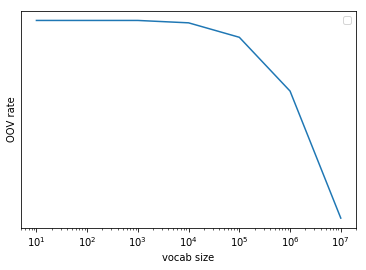

In [7]:
ov.plot_oov_rates(oov_rates)

##### tuned char-model

In [8]:
GEN_DATA_PATH = "data/generated/hd150_cl50_3_bng_tr_chr_50/"
MODEL_PATH = f"./rnnlm_models/hd150_cl50_3_bng_tr_chr_50"

from pathlib import Path
Path(GEN_DATA_PATH).mkdir(parents=True, exist_ok=True)

!bash gen_script.sh $GEN_DATA_PATH $MODEL_PATH

In [9]:
# Decoding generated texts
sentpiece.desegmentation("data/generated/hd150_cl50_3_bng_tr_chr_50/100.txt", "bng_train_50")

In [15]:
dir_path="data/generated/hd150_cl50_3_bng_tr_chr_50/"
oov_rates = {}
for i in range(1,8):
    file=10**i
    print(file)
    if str(file)+"_desegmented.txt" not in os.listdir(dir_path):
        sentpiece.desegmentation(dir_path+str(file)+".txt", "bng_train_50")
        
    add_vocab = ov.get_vocab(dir_path+str(file)+"_desegmented.txt")
    oov_rates[file] = ov.compute_oov_rate(ov.augment_vocab(train_vocab, add_vocab), test_vocab)
print(oov_rates)

10
100
1000
10000
100000
1000000
10000000
{10: 0.13434656741108353, 100: 0.13434656741108353, 1000: 0.13434656741108353, 10000: 0.13424317617866005, 100000: 0.13306451612903225, 1000000: 0.1260545905707196, 10000000: 0.11126964433416046}


No handles with labels found to put in legend.


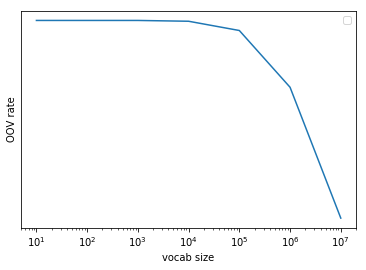

In [14]:
ov.plot_oov_rates(oov_rates)

### baseline small word-level model

In [8]:
GEN_DATA_PATH = "data/generated/hd40_cl9999_3_bng_tr_chr_600/"
MODEL_PATH = f"./rnnlm_models/hd40_cl9999_3_bng_tr_chr_600"

from pathlib import Path
Path(GEN_DATA_PATH).mkdir(parents=True, exist_ok=True)

!bash gen_script.sh $GEN_DATA_PATH $MODEL_PATH

In [9]:
# inspect 100.txt
sentpiece.desegmentation("data/generated/hd40_cl9999_3_bng_tr_chr_600/100.txt", "bng_train_600")

##### OOV comparison

In [10]:
train_vocab, test_vocab = ov.get_vocab(TRAIN_DATA_PATH), ov.get_vocab(TEST_DATA_PATH) 

dir_path="data/generated/hd40_cl9999_3_bng_tr_chr_600/"
oov_rates = {}
for i in range(1,8):
    file=10**i
    print(file)
    if str(file)+"_desegmented.txt" not in os.listdir(dir_path):
        sentpiece.desegmentation(dir_path+str(file)+".txt", "bng_train_600")
        
    add_vocab = ov.get_vocab(dir_path+str(file)+"_desegmented.txt")
    oov_rates[file] = ov.compute_oov_rate(ov.augment_vocab(train_vocab, add_vocab), test_vocab)
print(oov_rates)

10
100
1000
10000
100000
1000000
10000000
{10: 0.13434656741108353, 100: 0.13434656741108353, 1000: 0.13430521091811415, 10000: 0.13407775020678248, 100000: 0.13114143920595533, 1000000: 0.12210504549214227, 10000000: 0.10483870967741936}


No handles with labels found to put in legend.


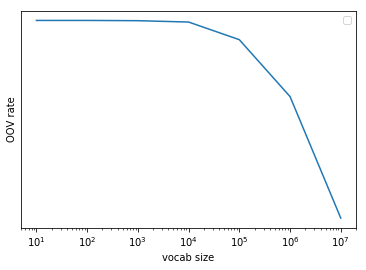

In [11]:
ov.plot_oov_rates(oov_rates)

### tuned small word-level model

In [6]:
GEN_DATA_PATH = "data/generated/hd200_cl600_3_bng_tr_chr_600/"
MODEL_PATH = f"./rnnlm_models/hd200_cl600_3_bng_tr_chr_600"

from pathlib import Path
Path(GEN_DATA_PATH).mkdir(parents=True, exist_ok=True)

!bash gen_script.sh $GEN_DATA_PATH $MODEL_PATH

In [7]:
# inspect 100.txt
sentpiece.desegmentation("data/generated/hd200_cl600_3_bng_tr_chr_600/100.txt", "bng_train_600")

##### OOV comparison

In [10]:
train_vocab, test_vocab = ov.get_vocab(TRAIN_DATA_PATH), ov.get_vocab(TEST_DATA_PATH) 

dir_path="data/generated/hd200_cl600_3_bng_tr_chr_600/"
oov_rates = {}
for i in range(1,8):
    file=10**i
    print(file)
    if str(file)+"_desegmented.txt" not in os.listdir(dir_path):
        sentpiece.desegmentation(dir_path+str(file)+".txt", "bng_train_600")
        
    add_vocab = ov.get_vocab(dir_path+str(file)+"_desegmented.txt")
    oov_rates[file] = ov.compute_oov_rate(ov.augment_vocab(train_vocab, add_vocab), test_vocab)
print(oov_rates)

10
100
1000
10000
100000
1000000
10000000
{10: 0.13434656741108353, 100: 0.13434656741108353, 1000: 0.13430521091811415, 10000: 0.13397435897435897, 100000: 0.13112076095947064, 1000000: 0.12074028122415219, 10000000: 0.1032051282051282}


No handles with labels found to put in legend.


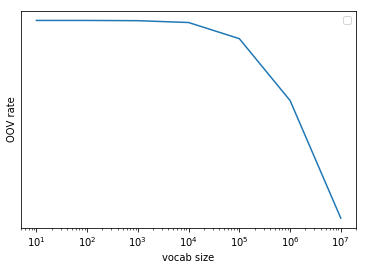

In [11]:
ov.plot_oov_rates(oov_rates)

### large word-level model

#### baseline

In [6]:
GEN_DATA_PATH = "data/generated/bng_tr_wd_2500/"
MODEL_PATH = f"./rnnlm_models/bng_tr_wd_2500"

from pathlib import Path
Path(GEN_DATA_PATH).mkdir(parents=True, exist_ok=True)

!bash gen_script.sh $GEN_DATA_PATH $MODEL_PATH

In [7]:
# inspect 100.txt
sentpiece.desegmentation("data/generated/bng_tr_wd_2500/100.txt", "bng_train_2500")

##### OOV comparison

In [8]:
train_vocab, test_vocab = ov.get_vocab(TRAIN_DATA_PATH), ov.get_vocab(TEST_DATA_PATH) 

dir_path="data/generated/bng_tr_wd_2500/"
oov_rates = {}
for i in range(1,8):
    file=10**i
    print(file)
    if str(file)+"_desegmented.txt" not in os.listdir(dir_path):
        sentpiece.desegmentation(dir_path+str(file)+".txt", "bng_train_2500")
        
    add_vocab = ov.get_vocab(dir_path+str(file)+"_desegmented.txt")
    oov_rates[file] = ov.compute_oov_rate(ov.augment_vocab(train_vocab, add_vocab), test_vocab)
print(oov_rates)

10
100
1000
10000
100000
1000000
10000000
{10: 0.13434656741108353, 100: 0.13434656741108353, 1000: 0.13432588916459884, 10000: 0.1339330024813896, 100000: 0.13078990901571547, 1000000: 0.12024400330851943, 10000000: 0.10186104218362282}


No handles with labels found to put in legend.


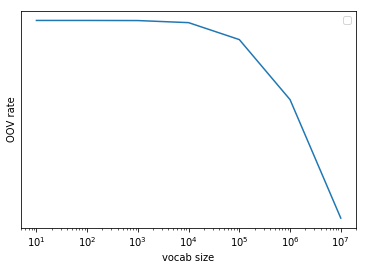

In [9]:
ov.plot_oov_rates(oov_rates)

### tuned large word model

In [ ]:
GEN_DATA_PATH = "data/generated/hid50_bng_tr_wd_1500/"
MODEL_PATH = f"./rnnlm_models/hid50_bng_tr_wd_1500"

from pathlib import Path
Path(GEN_DATA_PATH).mkdir(parents=True, exist_ok=True)

!bash gen_script.sh $GEN_DATA_PATH $MODEL_PATH

In [ ]:
# inspect 100.txt
sentpiece.desegmentation("data/generated/hid50_bng_tr_wd_1500/100.txt", "bng_train_1500")

##### OOV comparison

In [6]:
train_vocab, test_vocab = ov.get_vocab(TRAIN_DATA_PATH), ov.get_vocab(TEST_DATA_PATH) 

dir_path="data/generated/hid50_bng_tr_wd_1500/"
oov_rates = {}
for i in range(1,8):
    file=10**i
    print(file)
    if str(file)+"_desegmented.txt" not in os.listdir(dir_path):
        sentpiece.desegmentation(dir_path+str(file)+".txt", "bng_train_1500")
        
    add_vocab = ov.get_vocab(dir_path+str(file)+"_desegmented.txt")
    oov_rates[file] = ov.compute_oov_rate(ov.augment_vocab(train_vocab, add_vocab), test_vocab)
print(oov_rates)

10
100
1000
10000
100000
1000000
10000000
{10: 0.13434656741108353, 100: 0.13434656741108353, 1000: 0.13434656741108353, 10000: 0.13409842845326717, 100000: 0.1326095947063689, 1000000: 0.1272125723738627, 10000000: 0.1153225806451613}


No handles with labels found to put in legend.


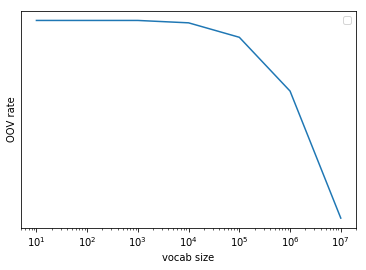

In [7]:
ov.plot_oov_rates(oov_rates)

# Analysis